### Алгоритм
#### 1 часть: подготовка к работе   
1.1. Установим необходимые библиотеки

In [1]:
%%bash
pip install numpy scipy scikit-image matplotlib

In [2]:
pip install pyTelegramBotAPI

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.9/242.9 kB 4.2 MB/s eta 0:00:00


In [3]:
pip install SpeechRecognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 34.3 MB/s eta 0:00:00


In [4]:
pip install pydub

In [5]:
pip install pydub opencv-python-headless opuslib


  Preparing metadata (setup.py) ... done
  Created wheel for opuslib: filename=opuslib-3.0.1-py3-none-any.whl size=12564 sha256=3d23f5528e64159a3ad449993eb0b56a1a85aa22fc57dc3f870e094c471accd8
  Stored in directory: /root/.cache/pip/wheels/94/54/3c/4cdec9effae0b0ed861a7623a7d2e2a9aa2d2cad179b9d71ea
Successfully built opuslib


1.2. Скачиваем выбранную CCS-модель

In [6]:
import torch
precision = 'fp32'
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd', model_math=precision)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn

In [7]:
ssd_model.to('cuda')
ssd_model.eval()

SSD300(
  (feature_extractor): ResNet(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplac

1.3. Монтируем Google-disk, на котором будем хранить вспомогательные материалы

In [8]:
from google.colab import drive
drive.mount('/content/drive')
torch.save(ssd_model.state_dict(), 'ssd_model.pth')
#torch.save(utils, 'ssd_utils.pth')

Mounted at /content/drive


1.4. Подгружаем необходимые библиотеки

In [9]:
import os
import time
import json
import webbrowser
from tqdm import tqdm
import subprocess
from pydub import AudioSegment
import telebot
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import speech_recognition as sr
import torchvision.transforms as T


#### 2 часть: реализация логики, которая будет обрабатывать данные, полученные от модели

In [18]:
def filter_foto(uri):
    inputs = [utils.prepare_input(uri)]
    tensor = utils.prepare_tensor(inputs, precision == 'fp16')
    with torch.no_grad():
        detections_batch = ssd_model(tensor)
    results_per_input = utils.decode_results(detections_batch)
    best_results_per_input = [utils.pick_best(results, 0.20) for results in results_per_input]
    classes_to_labels = utils.get_coco_object_dictionary()

    for image_idx in range(len(best_results_per_input)):
        fig, ax = plt.subplots(1)
        image = inputs[image_idx] / 2 + 0.5
        ax.imshow(image)
        bboxes, classes, confidences = best_results_per_input[image_idx]

        for idx in range(len(bboxes)):
            if (confidences[idx] > 0.55):
                left, bot, right, top = bboxes[idx]
                x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
                rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))

    fig.canvas.draw()
    processed_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    processed_image = processed_image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    ax.clear()
    plt.close(fig)

    return processed_image



In [20]:
def process_video(input_video_path, output_video_path, frame_interval=5):
    cap = cv2.VideoCapture(input_video_path)
    frame_count = 0
    frames = []

    os.makedirs(output_video_path, exist_ok=True)

    fig, ax = plt.subplots(1)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    original_fps = cap.get(cv2.CAP_PROP_FPS)

    for frame_num in tqdm(range(total_frames)):
        ret, frame = cap.read()

        if not ret:
            break
        if frame_num % frame_interval != 0:
            continue

        frame_filename = os.path.join(output_video_path, f"frame_{frame_count}.jpg")
        output_filename = os.path.join(output_video_path, f"output_frame_{frame_count}.jpg")

        cv2.imwrite(frame_filename, frame)
        processed_image = filter_foto(frame_filename)

        if processed_image is not None:
            frames.append(processed_image)

        frame_count += 1

    cap.release()

    if frames:
        height, width, layers = frames[0].shape
        output_fps = original_fps / frame_interval
        video = cv2.VideoWriter(output_video_path + "/video.mp4", cv2.VideoWriter_fourcc(*"mp4v"), output_fps, (width, height))
        for frame in frames:
            video.write(frame)

        cv2.destroyAllWindows()
        video.release()

    return frame_count

  0%|          | 0/10739 [00:00<?, ?it/s]

100%|██████████| 10739/10739 [10:07<00:00, 17.68it/s]


2148

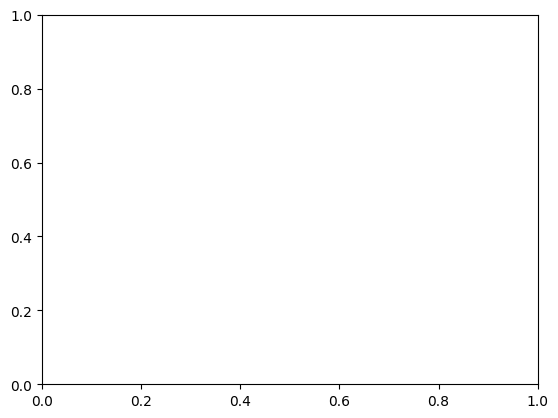

In [21]:
input_video_path = "/content/drive/MyDrive/dl/babycats.mp4"
output_video_path = "/content/drive/MyDrive/dl/output_frames"
process_video(input_video_path, output_video_path)

